In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torchsummary import summary
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import pandas as pd

In [2]:

    
def plot_losses(train_losses, test_losses, model_name = None, ylim = None):
    """
    Plots the training and test losses.

    Parameters:
    - train_losses: A list of training loss values.
    - test_losses: A list of test loss values.
    - ylim: Optional tuple specifying the y-axis limits.
    """
    # Set the Seaborn theme
    sns.set_theme(style="darkgrid")

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')

    # Add title and labels
    plt.title(f'Training and Test Loss. Model: {model_name}', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    # Add legend
    plt.legend()

    # Optionally, set the ylim if specified
    if ylim is not None:
        plt.ylim(ylim)

    # Show the plot
    plt.show()

In [3]:
class CustomDataset(Dataset):
    def __init__(self, inputs, targets, use_percentage=1.0):
        # Assuming inputs and targets are PyTorch tensors
        assert 0 < use_percentage <= 1, "use_percentage must be within (0, 1)."
        num_samples = int(len(inputs) * use_percentage)
        self.inputs = inputs[:num_samples]
        self.targets = targets[:num_samples]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


Loading Data and Filtering Extreme Values

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

data = {}
inputs = {}
targets = {}
filter = False
# Define zero-cost proxy metric names
metric_names = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 'snip', 'synflow', 'zen', 'flops', 'params']

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    # Load the data
    file = '/home/laurie2905/mase_ADL/mase/NASLib/naslib/data/zc_nasbench201.json'
    with open(file,'r') as f:
        data[data_type] = json.load(f)[data_type]


    # Initialize lists to hold filtered architectures and their corresponding targets
    filtered_inputs = []
    filtered_targets = []
    arch_removed_count = 0
    for arch in data[data_type].keys():
        arch_metrics = [data[data_type][arch].get(metric_name, {'score': 0})['score'] for metric_name in metric_names]
        
        if filter:
            # Check if any metric value for this architecture is above 10^6 or below -1e5
            if any(score > 1e5 or score < -1e5 for score in arch_metrics):
                # Increment count of architectures removed
                arch_removed_count += 1
            else:
                # Only include architectures that pass the filter
                filtered_inputs.append(arch_metrics)
                filtered_targets.append(data[data_type][arch]['val_accuracy'])
        else:
            # Include all architectures
            filtered_inputs.append(arch_metrics)
            filtered_targets.append(data[data_type][arch]['val_accuracy'])

    print(f"Number of architectures removed from ({data_type}):", arch_removed_count)

    # Convert lists to numpy arrays
    inputs[data_type] = np.array(filtered_inputs)
    targets[data_type] = np.array(filtered_targets)

Number of architectures removed from (cifar10): 0
Number of architectures removed from (cifar100): 0
Number of architectures removed from (ImageNet16-120): 0


In [5]:
import scipy.stats
import pandas as pd

# Assuming metric_names is defined
# Assuming inputs and targets are dictionaries with keys as dataset names and values as arrays described above

# Initialize a list to store results
results = []

# Loop over each dataset
for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    # Calculate correlations for each metric
    for i, metric_name in enumerate(metric_names):
        # Retrieve the metric values and targets for the current dataset
        metric_values = inputs[data_type][:, i]  # Assuming each column in inputs corresponds to a different metric
        validation_accuracies = targets[data_type]
        
        # Spearman's rank correlation
        spearman_corr, spearman_p = scipy.stats.spearmanr(metric_values, validation_accuracies)
        
        # Kendall's tau correlation
        kendall_tau, kendall_p = scipy.stats.kendalltau(metric_values, validation_accuracies)
        
        # Append results
        results.append({
            'Metric Name': metric_name,
            "Dataset": data_type,
            'Spearman Correlation': spearman_corr,
            'Kendall Tau': kendall_tau
        })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Print the results table
# print(results_df)

# Create separate DataFrames for Spearman Correlation and Kendall Tau
spearman_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Spearman Correlation')
kendall_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Kendall Tau')

# Rename columns for clarity
spearman_df.columns = [f'Spearman {col}' for col in spearman_df.columns]
kendall_df.columns = [f'Kendall {col}' for col in kendall_df.columns]

# Join the two DataFrames on Metric Name
final_df = spearman_df.join(kendall_df).reset_index()

# Exclude non-numeric columns (e.g., 'Metric Name') from the calculation
numeric_columns = final_df.select_dtypes(include=[np.number])

# Calculate the average of Spearman and Kendall values across all datasets for each metric, using only numeric columns
final_df['Average'] = numeric_columns.mean(axis=1)

# Sort the DataFrame based on the average value, descending (higher means better correlation)
ranked_df = final_df.sort_values(by='Average', ascending=False).reset_index(drop=True)

# Print the ranked DataFrame
print(ranked_df)


   Metric Name  Spearman ImageNet16-120  Spearman cifar10  Spearman cifar100  \
0         nwot                 0.779770          0.774732           0.804861   
1      synflow                 0.750775          0.732858           0.761348   
2        jacov                 0.718699          0.752316           0.716130   
3       params                 0.690554          0.715431           0.724997   
4      l2_norm                 0.691193          0.679066           0.712615   
5        flops                 0.672059          0.690501           0.704714   
6         snip                 0.578059          0.595012           0.635285   
7    grad_norm                 0.578082          0.590341           0.636035   
8      epe_nas                 0.334165          0.713964           0.607124   
9        grasp                 0.547709          0.518633           0.545008   
10      fisher                 0.489502          0.506389           0.547300   
11         zen                 0.400277 

In [6]:
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(13, 1)
        # 3 inputs (zc metrics), 1 output (accuracy)

    def forward(self, x):
        return self.linear(x)

In [7]:
class XGBoostWrapper:
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
        self.y_pred = {}
    
    def fit(self, train_loader):
        X_train, y_train = self._concatenate_loader_data(train_loader)
        self.model.fit(X_train, y_train)
    
    def predict(self, data_loader):
        X, _ = self._concatenate_loader_data(data_loader)
        return self.model.predict(X)
    
    def _concatenate_loader_data(self, loader):
        inputs_list, targets_list = [], []
        for inputs_batch, targets_batch in loader:
            # Assuming inputs are tensors and need to be converted to NumPy arrays
            inputs_list.append(inputs_batch.numpy())
            targets_list.append(targets_batch.numpy())
        # Concatenate all batches
        X = np.concatenate(inputs_list, axis=0)
        y = np.concatenate(targets_list, axis=0)
        return X, y
    
    def evaluate(self, data_loader):
        X, y_true = self._concatenate_loader_data(data_loader)
        self.y_pred = self.model.predict(X)
        return self.y_pred

In [8]:
class NonLinearModel(nn.Module):
    def __init__(self, input_size = 13, num_layers = 3, hidden_units = 5, output_size = 1):
        super(NonLinearModel, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            in_features = input_size if i == 0 else hidden_units
            self.layers.append(nn.Linear(in_features, hidden_units))
        self.final = nn.Linear(hidden_units, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return self.final(x)

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
import copy
def train_model(model, inputs, targets, name, epochs=25, batch_size=32, patience=3):
     
        # Convert lists to PyTorch tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    # Further split the train+validation set into training and validation sets
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(
        inputs_tensor, targets_tensor, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2 of the original dataset
    )

    # Create CustomDataset instances for each set
    train_dataset = CustomDataset(inputs_train, targets_train, use_percentage = 1)
    val_dataset = CustomDataset(inputs_val, targets_val, use_percentage = 1)

    best_acc = 0.0
    epochs_no_improve = 0

    if name != "XGBoost":

        batch_size = 32  # Adjustable batch size
        
        best_model_wts = copy.deepcopy(model.state_dict())

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        
        
        # Setup for early stopping
        early_stopping_counter = 0
        best_val_loss = float("inf")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        criterion = nn.L1Loss()
        optimizer = optim.RMSprop(model.parameters(), lr=0.002, weight_decay=1e-5)
        
        for epoch in range(epochs):
            model.train()
            for inputs_batch, targets_batch in train_loader:
                inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
                optimizer.zero_grad()
                outputs = model(inputs_batch)
                loss = criterion(outputs, targets_batch)
                loss.backward()
                optimizer.step()

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs_batch, targets_batch in val_loader:
                    inputs_batch, targets_batch = inputs_batch.to(device), targets_batch.to(device)
                    outputs = model(inputs_batch)
                    loss = criterion(outputs, targets_batch)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f'Epoch {epoch+1}, Val Loss: {val_loss:.4f}')
            
            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                early_stopping_counter = 0  # reset counter if validation loss improves
            else:
                early_stopping_counter += 1  # increment counter if no improvement
                if early_stopping_counter >= patience:
                    print(f'Early stopping triggered after epoch {epoch+1}')
                    break  # Exit the training loop
                
        model.load_state_dict(best_model_wts)     
    else:

        batch_size = 32  # Adjustable batch size

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize XGBoost with the wrapper
        model = XGBoostWrapper()

        # Fit the model to the training data
        model.fit(train_loader)
        

    return model

In [11]:
def reset_weights(m):
    '''
    Try resetting model weights to avoid weight leakage.
    '''
    if isinstance(m, nn.Linear):
        m.reset_parameters()

datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
input_size = 13
models = {'NonLinearModel': NonLinearModel(), 'LinearModel': LinearModel(), 'XGBoost': XGBoostWrapper()}
# models = {'XGBoost': XGBoostWrapper()}
        
trained_models = {}
test_dataset = {}
for name, model_instance in models.items():
    trained_models[name] = {}  # Initialize the dictionary for each model
    test_dataset[name] = {}
    for dataset in datasets:
        print(f"Training {name} on {dataset}")
        # Re-instantiate a new model instance for each dataset
        
                                # Split the data into train+validation and test sets
        inputs_train, inputs_test, targets_train, targets_test = train_test_split(
            inputs[dataset], targets[dataset], test_size=0.2, random_state=42
        )
        
        test_dataset[name][dataset] = CustomDataset(inputs_test, targets_test, use_percentage = 1)
        
        model_instance = model_instance.__class__()  # Re-instantiate model
        
        if name != "XGBoost":
            model_instance.apply(reset_weights)  # Reset model weights
        # Proceed with training the model on the dataset...

        trained_models[name][dataset] = train_model(model_instance, inputs_train, targets_train, name, epochs=50, batch_size=32, patience=10)



Training NonLinearModel on cifar10


/home/laurie2905/anaconda3/envs/mase/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Epoch 1, Val Loss: 82.5387
Epoch 2, Val Loss: 3.0488
Epoch 3, Val Loss: 2.5834
Epoch 4, Val Loss: 3.4056
Epoch 5, Val Loss: 3.9016
Epoch 6, Val Loss: 2.8067
Epoch 7, Val Loss: 3.3165
Epoch 8, Val Loss: 2.8051
Epoch 9, Val Loss: 2.5066
Epoch 10, Val Loss: 2.2098
Epoch 11, Val Loss: 2.3628
Epoch 12, Val Loss: 2.9749
Epoch 13, Val Loss: 2.7861
Epoch 14, Val Loss: 2.8122
Epoch 15, Val Loss: 2.6130
Epoch 16, Val Loss: 2.2712
Epoch 17, Val Loss: 2.2467
Epoch 18, Val Loss: 2.6844
Epoch 19, Val Loss: 2.2091
Epoch 20, Val Loss: 3.2199
Epoch 21, Val Loss: 2.8726
Epoch 22, Val Loss: 2.5929
Epoch 23, Val Loss: 2.1151
Epoch 24, Val Loss: 3.3731
Epoch 25, Val Loss: 2.0755
Epoch 26, Val Loss: 2.9847
Epoch 27, Val Loss: 2.6274
Epoch 28, Val Loss: 3.0063
Epoch 29, Val Loss: 2.8968
Epoch 30, Val Loss: 2.1019
Epoch 31, Val Loss: 2.0997
Epoch 32, Val Loss: 3.5090
Epoch 33, Val Loss: 2.2953
Epoch 34, Val Loss: 2.2814
Epoch 35, Val Loss: 2.3330
Early stopping triggered after epoch 35
Training NonLinearModel

Predicting All

In [12]:
def rank_and_check(metric_values, accuracy_values):
    
    # Randomly select 1000 indices to simulate choosing 1000 architectures, without replacement
    indices = np.random.choice(len(metric_values), size=1000, replace=False)
    
    # Select the metric values and accuracy values for the sampled architectures
    sampled_metric_values = metric_values[indices]
    sampled_accuracy_values = accuracy_values[indices]

    # Rank the sampled architectures based on the metric values
    sorted_by_metric_indices = np.argsort(-sampled_metric_values)
    
    # Find the actual best architecture within the sampled set by validation accuracy
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_metric_accuracy = sampled_accuracy_values[sorted_by_metric_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]
    
    # Calculate the difference in accuracy between the best model chosen by the metric and the actual best model
    accuracy_difference = actual_best_accuracy - best_by_metric_accuracy
    
    # Find the position of the actual best model in the metric-based rankings of the sampled set
    actual_best_position = np.where(sorted_by_metric_indices == actual_best_index)[0][0] + 1
    
    # Find the top 10 models by actual validation accuracy within the sampled set
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    
    # Find how many of the top 10 models by accuracy are in the top 10 models chosen by the metric within the sampled set
    top10_metric_indices = sorted_by_metric_indices[:10]
    top10_accuracy_in_top10_metric = len(set(top10_accuracy_indices) & set(top10_metric_indices))
    
    return accuracy_difference, top10_accuracy_in_top10_metric, actual_best_position

In [13]:
def rank_and_check_nn(model, inputs, targets, device='cpu'):
    
    if model.__class__.__name__ != 'XGBoostWrapper':
        model.to(device)
        model.eval()  # Set the model to evaluation mode

    # Convert lists to PyTorch tensors
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    target_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)
    # Assuming inputs and targets are already tensors
    inputs, targets = inputs_tensor.to(device), target_tensor.to(device)
    
    with torch.no_grad():
        # Get model predictions
        predictions = model(inputs)
        
    # Convert predictions to the same shape as targets for comparison
    predictions = predictions.squeeze()
    
    # Randomly select 1000 indices to simulate choosing 1000 architectures, without replacement
    indices = np.random.choice(len(predictions), size=1000, replace=False)
    
    # Select the predictions and accuracy values for the sampled architectures
    sampled_predictions = predictions[indices].cpu().numpy()
    sampled_accuracy_values = targets[indices].cpu().numpy()

    # Rank the sampled architectures based on the predictions
    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    
    # Find the actual best architecture within the sampled set by validation accuracy
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]
    
    # Calculate the difference in accuracy between the best model chosen by the prediction and the actual best model
    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    
    # Find the position of the actual best model in the prediction-based rankings of the sampled set
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1
    
    # Find how many of the top 10 models by accuracy are in the top 10 models chosen by the prediction within the sampled set
    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    # print(top10_predictions_indices)
    # Flatten the arrays to ensure they're 1D before converting to lists
    top10_predictions_indices_list = top10_predictions_indices.flatten().tolist()
    top10_accuracy_indices_list = top10_accuracy_indices.flatten().tolist()
    # Now, you can safely use set operations since list elements are integers and thus hashable
    top10_accuracy_in_top10_prediction = len(set(top10_accuracy_indices_list) & set(top10_predictions_indices_list))
        
    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position


In [14]:
from torch.utils.data import DataLoader, TensorDataset
def rank_and_check_xgb(model, inputs, targets, batch_size=32):
    # This check is to see if we're dealing with an XGBoost model
    if isinstance(model, XGBoostWrapper):
        # Create a DataLoader for the inputs and targets
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
        targets_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)
        
        # Use the DataLoader compatible with XGBoostWrapper
        dataset = TensorDataset(inputs_tensor, targets_tensor)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        # Predictions are made inside the XGBoostWrapper using its predict method
        predictions = model.predict(data_loader)
        # Targets need to be flattened for comparison, assuming they're not single-dimensional
        targets_flat = targets_tensor.view(-1).numpy()
        
    else:
        raise ValueError("Model must be an instance of XGBoostWrapper.")
 # Randomly select 1000 indices to simulate choosing 1000 architectures, without replacement
    indices = np.random.choice(len(predictions), size=1000, replace=False)
    
    # Select the predictions and accuracy values for the sampled architectures
    sampled_predictions = predictions[indices]
    sampled_accuracy_values = targets_flat[indices]

    # Rank and compare as before
    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]

    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1

    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    
    top10_accuracy_in_top10_prediction = len(set(top10_predictions_indices.tolist()) & set(top10_accuracy_indices.tolist()))

    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position

In [15]:
datasets = ['cifar10', 'cifar100', 'ImageNet16-120']  # Example dataset names
n_times = 1000  # Number of times to repeat the experiment


models = {
    'NonLinearModel': NonLinearModel(),
    'LinearModel': LinearModel(),
    'XGBoost': XGBoostWrapper()  # Assuming this is correctly implemented to fit in this context
}

metric_names = ['epe_nas', 'fisher', 'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'plain', 
                'snip', 'synflow', 'zen', 'flops', 'params', 'NonLinearModel', 'LinearModel', 'XGBoost']

# Initialize structure to store results
results = {dataset: {metric_name: {'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': []}
                     for metric_name in metric_names} for dataset in datasets}



# Perform the experiment
for dataset in datasets:
    for metric_name in metric_names[0:13]:
        metric_index = metric_names.index(metric_name)  # Get index of the metric from the names list
        metric_values = inputs[dataset][:, metric_index]  # Metric values for all architectures
        accuracy_values = targets[dataset]  # Validation accuracies for all architectures
        
        for _ in range(n_times):
            accuracy_diff, top10_count, actual_best_position = rank_and_check(metric_values, accuracy_values)
            results[dataset][metric_name]['accuracy_diffs'].append(accuracy_diff)
            results[dataset][metric_name]['top10_accuracy_count'].append(top10_count)
            results[dataset][metric_name]['actual_best_positions'].append(actual_best_position)

for name, model_dict in trained_models.items():
    for dataset in datasets:
        
        data = test_dataset[name][dataset]

        input_values = data.inputs.tolist()
        accuracy_values = data.targets.tolist()
        model_instance = model_dict[dataset]

        for _ in range(n_times):
            if name != 'XGBoost':
                # Assuming rank_and_check_nn is adjusted to work directly with PyTorch models
                accuracy_diff, top10_count, actual_best_position = rank_and_check_nn(model_instance, torch.tensor(input_values, dtype=torch.float32), torch.tensor(accuracy_values, dtype=torch.float32), device='cpu')
                accuracy_diff = accuracy_diff[0]
            else:
                accuracy_diff, top10_count, actual_best_position = rank_and_check_xgb(model_instance, input_values, accuracy_values)

            results[dataset][name]['accuracy_diffs'].append(accuracy_diff)
            results[dataset][name]['top10_accuracy_count'].append(top10_count)
            results[dataset][name]['actual_best_positions'].append(actual_best_position)
            
            
# Aggregate results
aggregate_results = {dataset: {metric_name: {'average_diff': np.mean(info['accuracy_diffs']),
                                             'average_top10_count': np.mean(info['top10_accuracy_count']),
                                             'average_actual_best_position': np.mean(info['actual_best_positions'])}
                               for metric_name, info in dataset_info.items()}
                    for dataset, dataset_info in results.items()}


/tmp/ipykernel_1143685/3149218795.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
/tmp/ipykernel_1143685/3149218795.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(targets, dtype=torch.float32).view(-1, 1)


In [16]:
# Flattening the aggregate_results into a list of dictionaries
flattened_results = []
for metric_name in metric_names:
    row = {'Metric Name': metric_name}
    for dataset in datasets:
        # Accessing the aggregate results for each dataset and metric
        agg_info = aggregate_results[dataset].get(metric_name, {})
        # Adding the dataset-specific results to the row
        row[f'{dataset} Avg. Acc. Diff'] = agg_info.get('average_diff', 0)
        row[f'{dataset} Avg. Top-10 Acc. Count'] = agg_info.get('average_top10_count', 0)
        row[f'{dataset} Avg. Best Model Pos.'] = agg_info.get('average_actual_best_position', 0)
    flattened_results.append(row)

# Creating the DataFrame from the flattened results
results_df = pd.DataFrame(flattened_results)

results_df.to_csv('saved_trial_data2.csv', index=False)

# Displaying the DataFrame
results_df

,Metric Name,cifar10 Avg. Acc. Diff,cifar10 Avg. Top-10 Acc. Count,cifar10 Avg. Best Model Pos.,cifar100 Avg. Acc. Diff,cifar100 Avg. Top-10 Acc. Count,cifar100 Avg. Best Model Pos.,ImageNet16-120 Avg. Acc. Diff,ImageNet16-120 Avg. Top-10 Acc. Count,ImageNet16-120 Avg. Best Model Pos.
0,epe_nas,3.043100,0.317,263.410,6.827380,0.344,287.581,8.074600,0.069,361.097
1,fisher,4.969300,0.000,660.997,10.419780,0.043,652.091,21.033400,0.039,495.156
2,grad_norm,4.887690,0.014,529.446,10.118920,0.139,500.468,20.279067,0.219,351.442
3,grasp,4.637070,0.001,413.000,9.062720,0.078,427.204,16.741700,0.198,282.135
4,jacov,2.666810,0.307,182.771,4.363700,0.533,146.766,6.326333,0.252,163.710
5,l2_norm,1.663340,0.281,109.503,2.769060,1.076,62.675,2.419900,1.885,73.750
6,nwot,1.684950,0.088,93.903,2.805680,0.853,66.685,2.375400,1.512,70.962
7,plain,7.197510,0.000,634.800,10.749060,0.002,596.196,16.390133,0.117,685.210
8,snip,4.886820,0.002,526.288,10.252460,0.207,490.067,19.968800,0.303,353.358
9,synflow,1.351070,1.283,37.535,2.143860,2.479,29.921,4.691233,2.275,29.162


In [17]:
def plot_model_correlations(model, test_loader, model_name = None, title_name = None):
    predicted_accuracies = []
    actual_accuracies = []
    
    if isinstance(model, torch.nn.Module):
        model.eval()
        with torch.no_grad():
            for inputs_batch, targets_batch in test_loader:
                # Ensure inputs are on the same device as the model
                inputs_batch = inputs_batch.to(next(model.parameters()).device)
                
                outputs_batch = model(inputs_batch)
                # Move outputs and targets to CPU, flatten, and convert to list
                predicted_accuracies.extend(outputs_batch.view(-1).cpu().tolist())
                actual_accuracies.extend(targets_batch.view(-1).cpu().tolist())
    
    # Handle non-PyTorch models (like XGBoost)
    else:
        predicted_accuracies = model.evaluate(test_loader)
        for inputs_batch, targets_batch in test_loader:
            actual_accuracies.extend(targets_batch.view(-1).cpu().tolist())
            
    predicted_accuracies_np = np.array(predicted_accuracies).flatten()
    actual_accuracies_np = np.array(actual_accuracies).flatten()
    
    spearman_corr, _ = spearmanr(predicted_accuracies_np, actual_accuracies_np)
    kendall_corr, _ = kendalltau(predicted_accuracies_np, actual_accuracies_np)
    
    
    
    # Plot Spearman's correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)
    plt.title(f'Spearman\'s Rank Correlation: {spearman_corr:.2f}. Model: {model_name}, Dataset: {title_name}', fontsize=15)
    plt.xlabel('Actual Test Accuracy', fontsize=12)
    plt.ylabel('Predicted Test Accuracy', fontsize=12)
    sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
    plt.grid(True)
    # plt.xlim([0, np.max(actual_accuracies_np) * 1.1])
    # plt.ylim([0, np.max(actual_accuracies_np) * 1.1])
    plt.show()
    
        # Plot Kendall's Tau correlation
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual_accuracies_np, y=predicted_accuracies_np)
    plt.title(f'Kendall\'s Tau Correlation: {spearman_corr:.2f}. Model: {model_name}, Dataset: {title_name}', fontsize=15)
    plt.xlabel('Actual Test Accuracy', fontsize=12)
    plt.ylabel('Predicted Test Accuracy', fontsize=12)
    sns.regplot(x=actual_accuracies_np, y=predicted_accuracies_np, scatter=False, ci=None, color="red")
    plt.grid(True)
    # plt.xlim([0, np.max(actual_accuracies_np) * 1.1])
    # plt.ylim([0, np.max(actual_accuracies_np) * 1.1])
    plt.show()
    
    return spearman_corr, kendall_corr

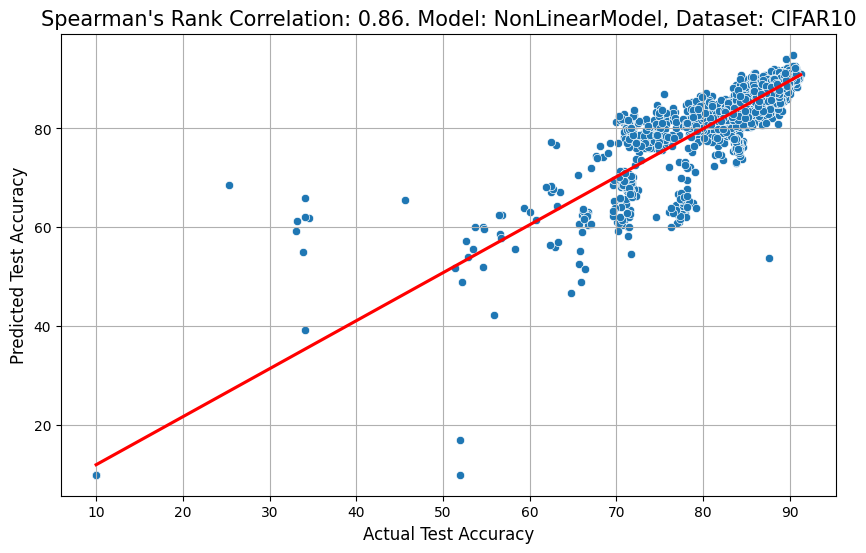

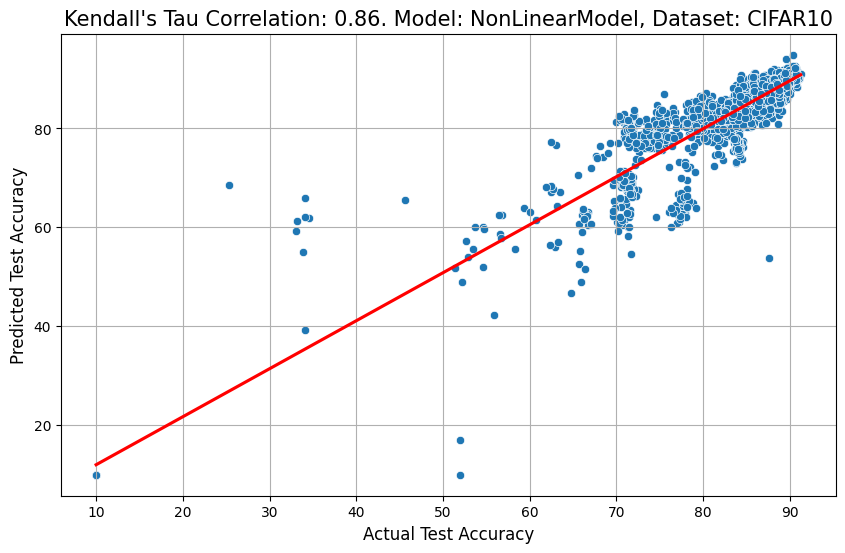

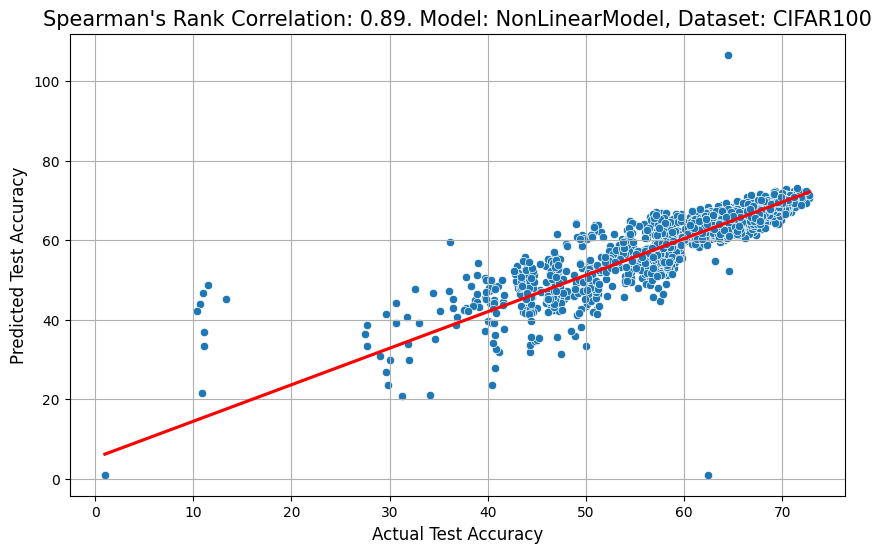

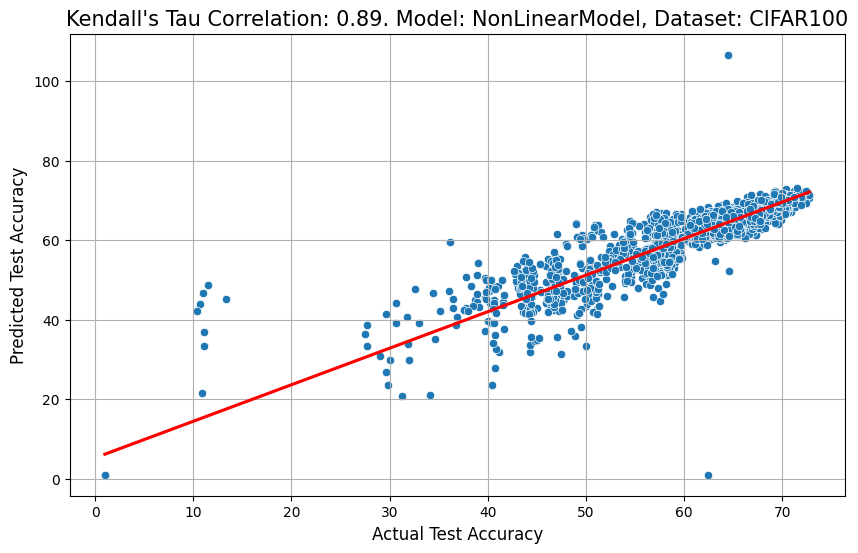

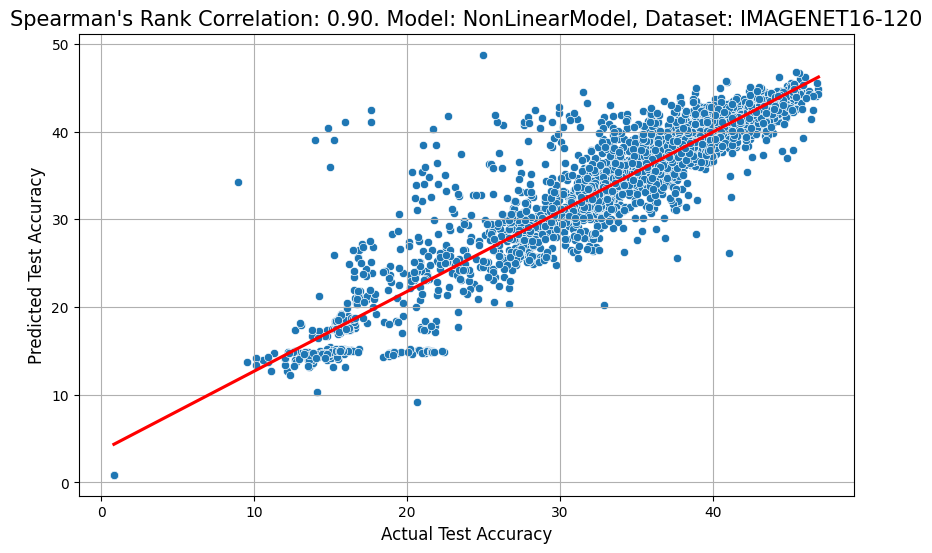

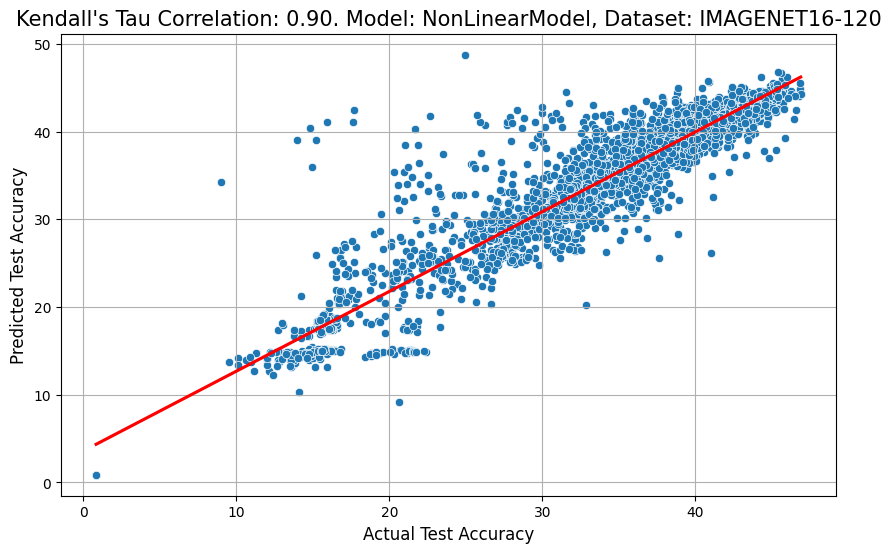

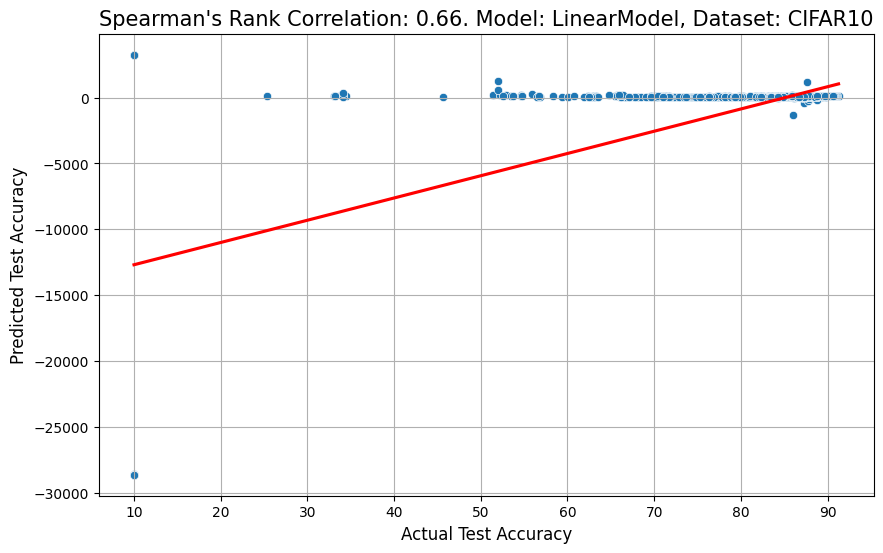

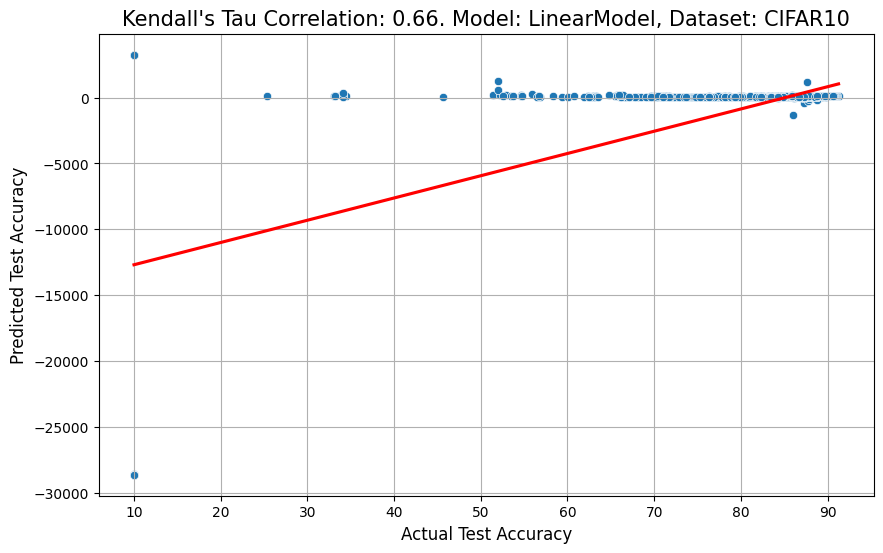

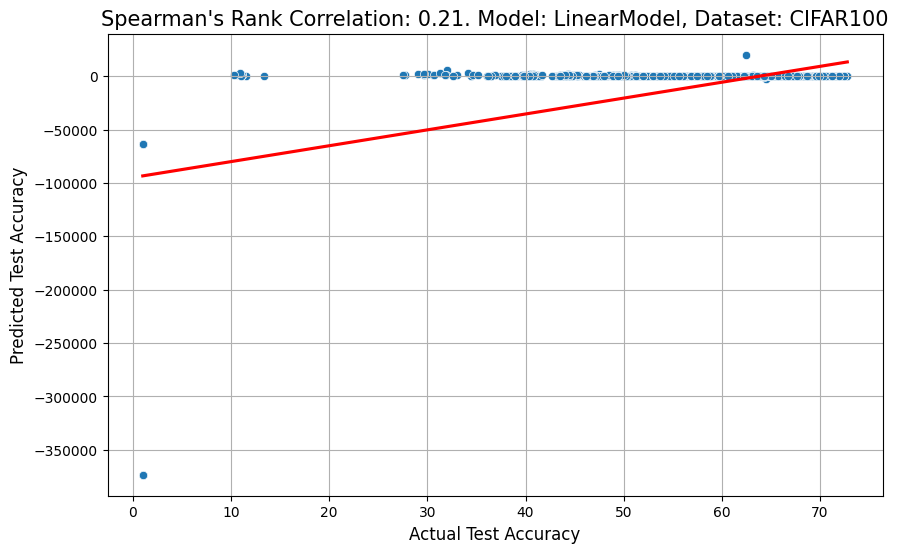

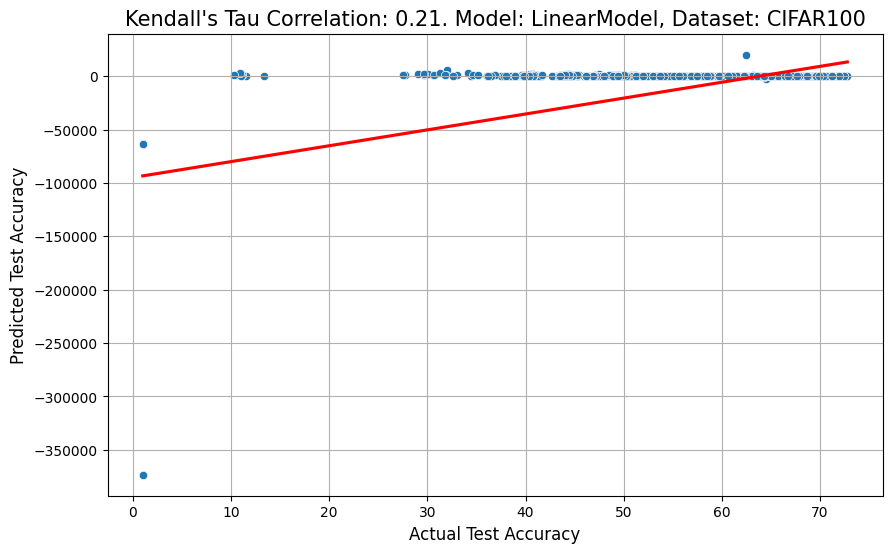

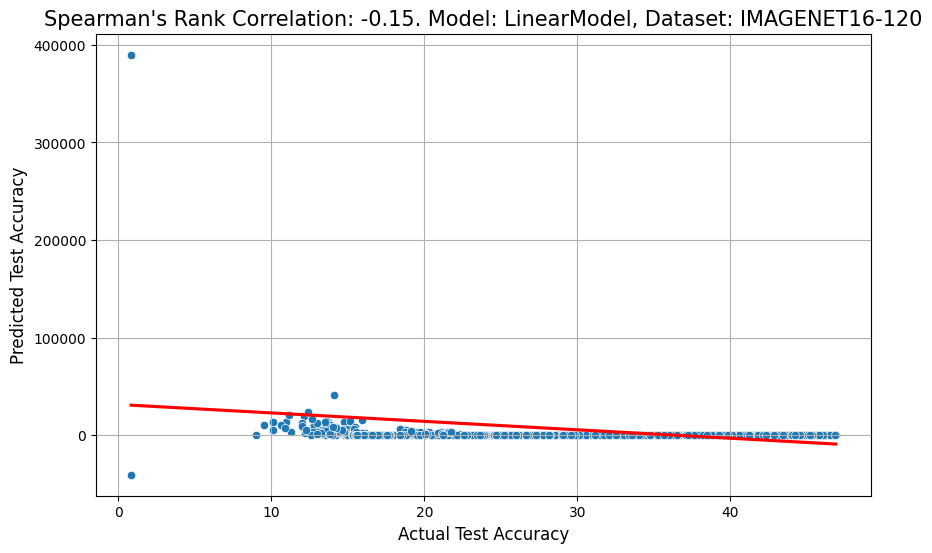

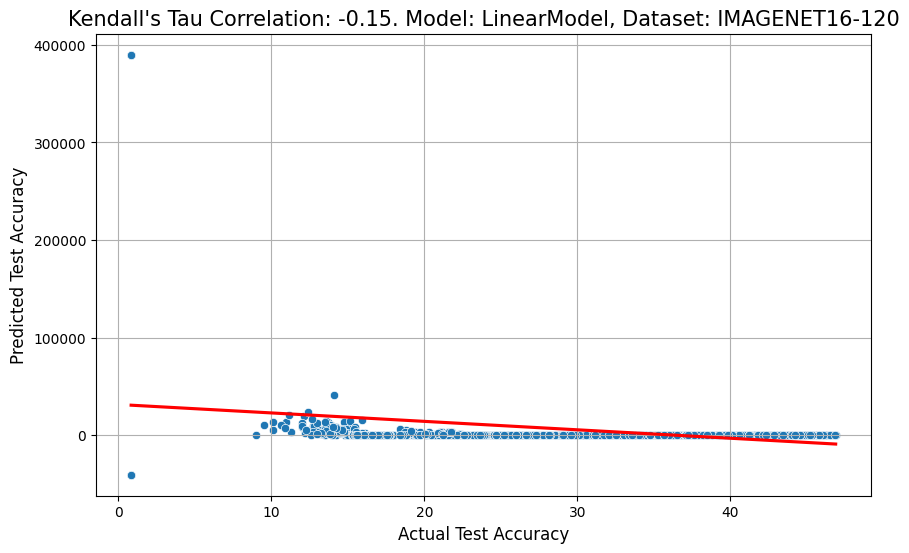

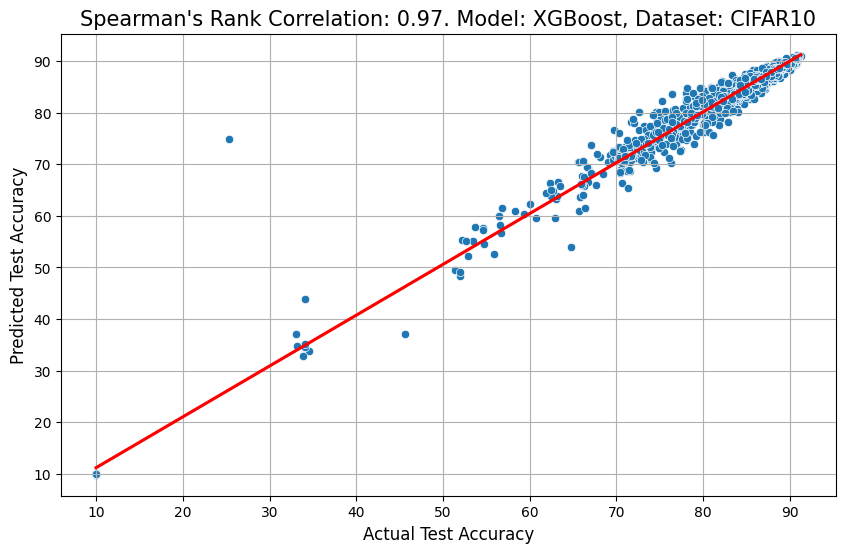

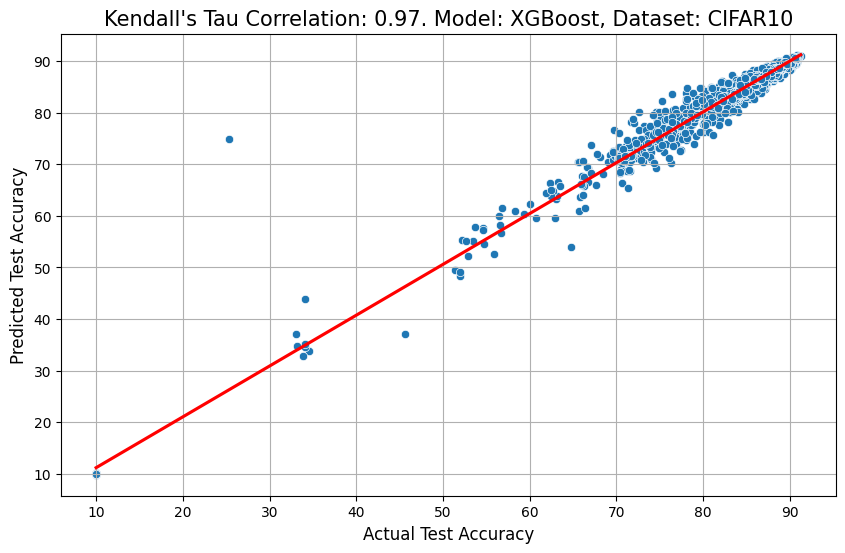

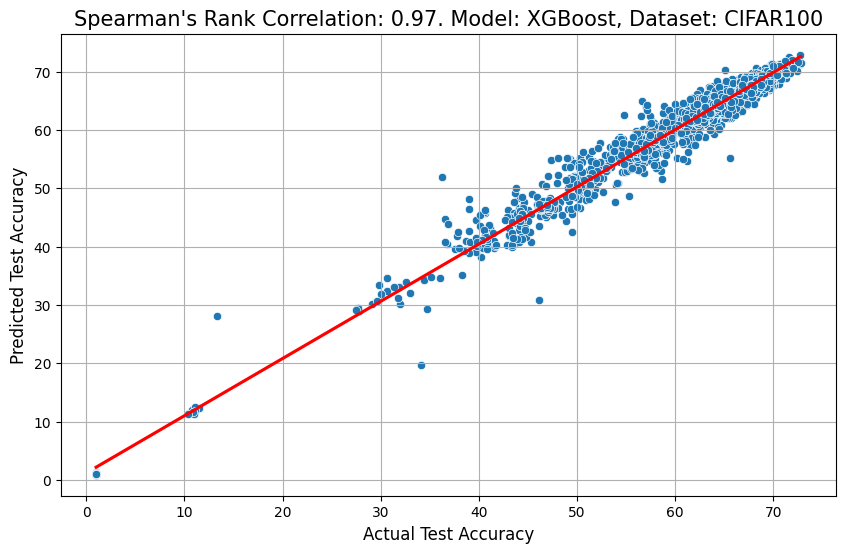

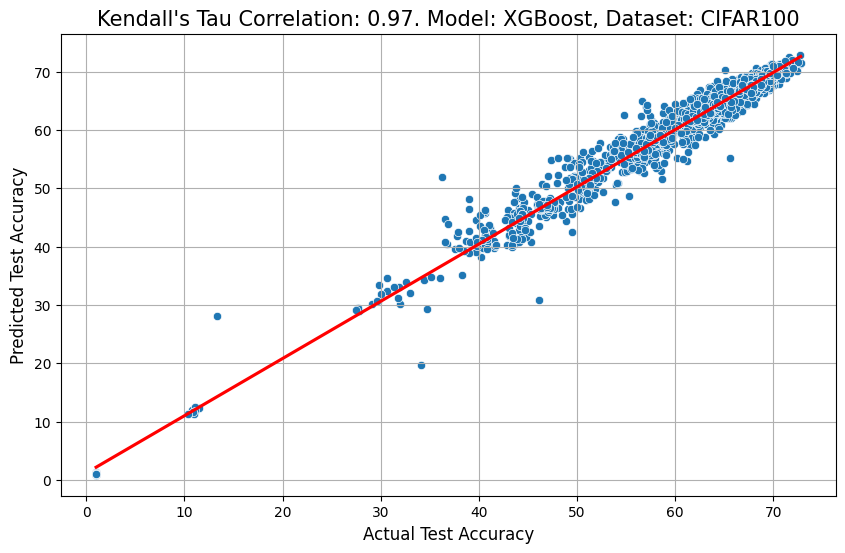

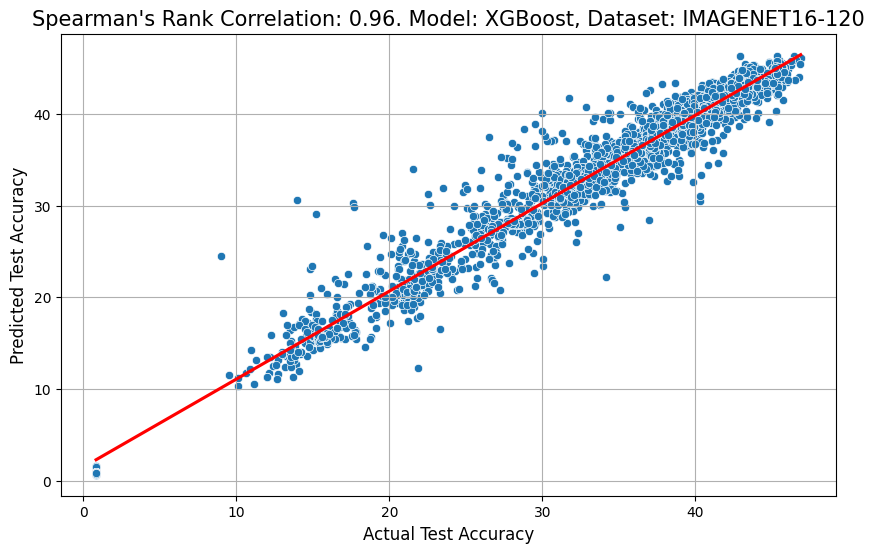

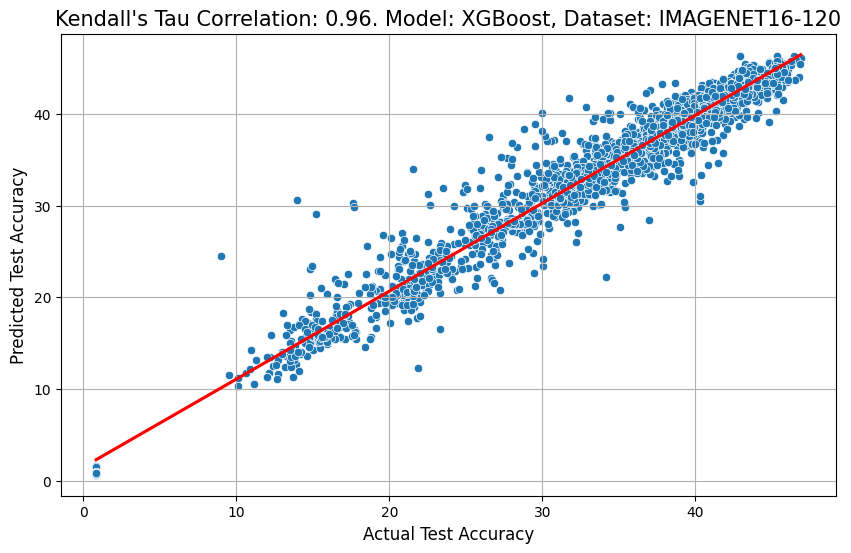

In [18]:
spearman_corr = {}
kendall_corr = {}

for name, model_dict in trained_models.items():
    spearman_corr[name] = {}
    kendall_corr[name] = {}
    for dataset in datasets:
        model_instance = model_dict[dataset]
        data = test_dataset[name][dataset]

        input_values = data.inputs.tolist()
        accuracy_values = data.targets.tolist()
        model_instance = model_dict[dataset]

        inputs_tensor = torch.tensor(input_values, dtype=torch.float32)
        targets_tensor = torch.tensor(accuracy_values, dtype=torch.float32).view(-1, 1)


        # Use the DataLoader compatible with XGBoostWrapper
        data = TensorDataset(inputs_tensor, targets_tensor)
        data_loader = DataLoader(data, shuffle=False)

        spearman_corr[name][dataset], kendall_corr[name][dataset] = plot_model_correlations(model_instance, data_loader, model_name = name, title_name = str(dataset).upper())


In [19]:

import scipy.stats
import pandas as pd

results = []

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    # General Metric Correlations
    for i, metric_name in enumerate(metric_names[:13]):  # Adjust as per your metrics list
        metric_values = inputs[data_type][:, i]
        validation_accuracies = targets[data_type]
        
        # Spearman's rank correlation and Kendall's tau correlation
        spearman, spearman_p = scipy.stats.spearmanr(metric_values, validation_accuracies)
        kendall, kendall_p = scipy.stats.kendalltau(metric_values, validation_accuracies)
        
        # Append general metric results
        results.append({
            'Metric Name': metric_name,
            "Dataset": data_type,
            'Spearman Correlation': spearman,
            'Kendall Tau': kendall
        })
    
    # Model-Specific Correlations (Adjusted)
    for model_name, datasets_corr in spearman_corr.items():
        if data_type in datasets_corr:  # Check if the dataset is in the model-specific dict
            spearman_value = datasets_corr[data_type]
            kendall_value = kendall_corr[model_name][data_type] if data_type in kendall_corr[model_name] else None
            
            # Append model-specific results
            results.append({
                'Metric Name': model_name,  # Using model name as metric
                "Dataset": data_type,
                'Spearman Correlation': spearman_value,
                'Kendall Tau': kendall_value
            })

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Pivot the DataFrame
spearman_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Spearman Correlation')
kendall_df = results_df.pivot(index='Metric Name', columns='Dataset', values='Kendall Tau')

# Rename columns for clarity
spearman_df.columns = [f'Spearman {col}' for col in spearman_df.columns]
kendall_df.columns = [f'Kendall {col}' for col in kendall_df.columns]

# Join the two DataFrames
final_df = spearman_df.join(kendall_df).reset_index()

# Calculate averages and sort
numeric_columns = final_df.select_dtypes(include=[np.number])
final_df['Average'] = numeric_columns.mean(axis=1)
ranked_df = final_df.sort_values(by='Average', ascending=False).reset_index(drop=True)

ranked_df


,Metric Name,Spearman ImageNet16-120,Spearman cifar10,Spearman cifar100,Kendall ImageNet16-120,Kendall cifar10,Kendall cifar100,Average
0,XGBoost,0.963517,0.968936,0.966437,0.849571,0.854975,0.849383,0.908803
1,NonLinearModel,0.900722,0.855857,0.889240,0.751983,0.676230,0.715816,0.798308
2,nwot,0.779770,0.774732,0.804861,0.596512,0.584873,0.618176,0.693154
3,synflow,0.750775,0.732858,0.761348,0.559920,0.536821,0.566504,0.651371
4,jacov,0.718699,0.752316,0.716130,0.546548,0.575380,0.548657,0.642955
5,params,0.690554,0.715431,0.724997,0.519184,0.538454,0.549952,0.623095
6,l2_norm,0.691193,0.679066,0.712615,0.501559,0.488936,0.518758,0.598688
7,flops,0.672059,0.690501,0.704714,0.485733,0.499667,0.514214,0.594481
8,snip,0.578059,0.595012,0.635285,0.432296,0.433213,0.472612,0.524413
9,grad_norm,0.578082,0.590341,0.636035,0.429675,0.428608,0.470839,0.522263


In [20]:
# Spearman DataFrame
spearman_df = ranked_df[['Metric Name', 'Spearman cifar10','Spearman cifar100','Spearman ImageNet16-120']].copy()

# Kendall DataFrame
kendall_df = ranked_df[['Metric Name', 'Kendall cifar10','Kendall cifar100','Kendall ImageNet16-120']].copy()

In [21]:
spearman_df = spearman_df.rename(columns={
    'Spearman cifar10': 'CIFAR-10',
    'Spearman cifar100': 'CIFAR-100',
    'Spearman ImageNet16-120': 'ImageNet16-120'
})

kendall_df = spearman_df.rename(columns={
    'Kendall cifar10': 'CIFAR-10',
    'Kendall cifar100': 'CIFAR-100',
    'Kendall ImageNet16-120': 'ImageNet16-120'
})

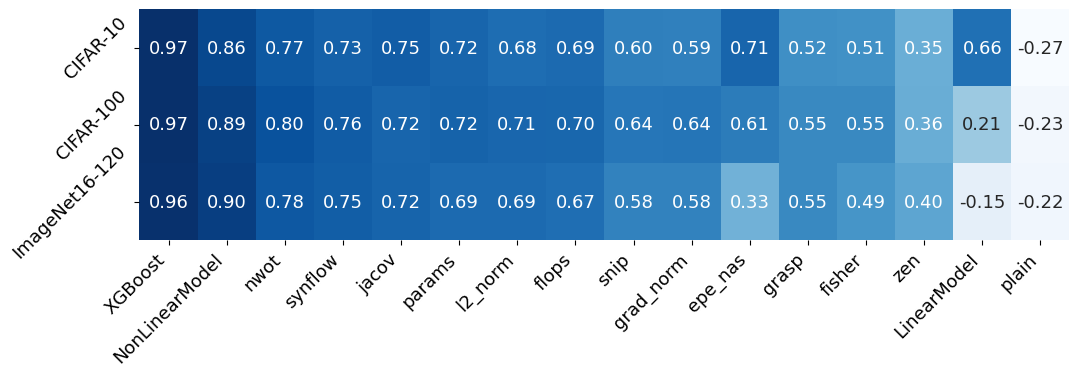

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})  # Update all font sizes to 12
# Transpose the DataFrame to get metric names on the x-axis
df_transposed = spearman_df.set_index('Metric Name').T  # 'T' transposes the DataFrame


plt.figure(figsize=(12, 3))  # Adjust figure size as needed
heatmap = sns.heatmap(df_transposed, cmap="Blues", annot=True, fmt=".2f", cbar=False)

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

# Remove the x-axis label
heatmap.set_xlabel('')

plt.show()

In [ ]:
kendall_df

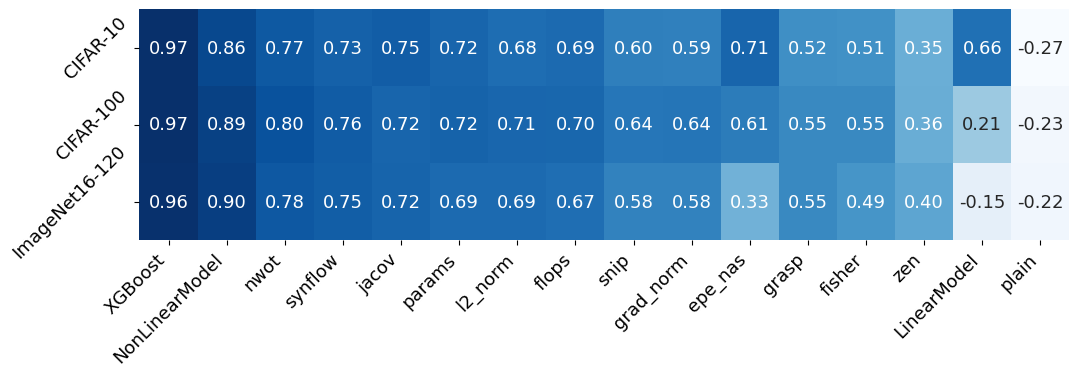

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})  # Update all font sizes to 12
# Transpose the DataFrame to get metric names on the x-axis
df_transposed_kendall = kendall_df.set_index('Metric Name').T  # 'T' transposes the DataFrame


plt.figure(figsize=(12, 3))  # Adjust figure size as needed
heatmap = sns.heatmap(df_transposed_kendall, cmap="Blues", annot=True, fmt=".2f", cbar=False)

# Rotate the x-axis labels for better readability if needed
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')

# Remove the x-axis label
heatmap.set_xlabel('')

plt.show()

In [24]:
loaded_df = pd.read_csv('saved_trial_data2.csv')


loaded_df = loaded_df.rename(columns={
    'cifar10 Avg. Acc. Diff': 'CIFAR-10: Average Difference Between Actual Best Model Accuracy and Its Predicted Accuracy',
    'cifar10 Avg. Top-10 Acc. Count': 'CIFAR-10, Average Count of Predicted Architectures Within the Top 10, Based on Actual Model Accuracy Rankings',
    'cifar10 Avg. Best Model Pos.': 'CIFAR-10, Average Ranking Position of the True Best Model Within Predicted Accuracy Rankings',
    'cifar100 Avg. Acc. Diff': 'CIFAR-100: Average Difference Between Actual Best Model Accuracy and Its Predicted Accuracy',
    'cifar100 Avg. Top-10 Acc. Count': 'CIFAR-100, Average Count of Predicted Architectures Within the Top 10, Based on Actual Model Accuracy Rankings',
    'cifar100 Avg. Best Model Pos.': 'CIFAR-100, Average Ranking Position of the True Best Model Within Predicted Accuracy Rankings',
    'ImageNet16-120 Avg. Acc. Diff': 'ImageNet16-120: Average Difference Between Actual Best Model Accuracy and Its Predicted Accuracy',
    'ImageNet16-120 Avg. Top-10 Acc. Count': 'ImageNet16-120, Average Count of Predicted Architectures Within the Top 10, Based on Actual Model Accuracy Rankings',
    'ImageNet16-120 Avg. Best Model Pos.': 'ImageNet16-120, Average Ranking Position of the True Best Model Within Predicted Accuracy Rankings',
})

loaded_df

# Filter columns for "Average Difference" and include "Metric Name"
Average_Difference_columns = [col for col in loaded_df.columns if "Average Difference" in col or "Metric Name" in col]
Average_Difference_df = loaded_df[Average_Difference_columns]

# Filter columns for "Average Count" and include "Metric Name"
Average_Count_columns = [col for col in loaded_df.columns if "Average Count" in col or "Metric Name" in col]
Average_Count_df = loaded_df[Average_Count_columns]

# Filter columns for "Average Ranking" and include "Metric Name"
Average_Ranking_columns = [col for col in loaded_df.columns if "Average Ranking" in col or "Metric Name" in col]
Average_Ranking_df = loaded_df[Average_Ranking_columns]

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(df, vmax_value, dp):
    
    df = df.copy()

    # Select only numeric columns for the mean calculation
    numeric_df = df.select_dtypes(include=[np.number])
    df['Average'] = numeric_df.mean(axis=1)
    # Calculate the mean across numeric columns only
    df['Average'] = numeric_df.mean(axis=1)

    # Sort the DataFrame based on the 'Average Across Datasets' column
    df = df.sort_values(by='Average', ascending=False)

    # Update the column headers with the modified names
    df.columns = ['Metric Name', 'CIFAR-10', 'CIFAR-100', 'ImageNet16-120', 'Average']

    # Setting plot font size
    plt.rcParams.update({'font.size': 13})  # Update all font sizes

    # Ensure 'Metric Name' is set as the index
    if 'Metric Name' in df.columns:
        df.set_index('Metric Name', inplace=True)

    # If 'Metric Name' is not a column or you've already set it as the index, proceed directly
    # Transposing the DataFrame to have identifiers (Metric Names) on the x-axis
    df_transposed = df.T  # Transpose the DataFrame

    plt.figure(figsize=(12, 3))  # Adjust figure size as needed
    heatmap = sns.heatmap(df_transposed, cmap="Blues", annot=True,  fmt=f".{dp}f", cbar=False, vmax=vmax_value)

    # Rotate the x-axis and y-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')

    # Remove the x-axis label for clarity
    heatmap.set_xlabel('')

    plt.show()


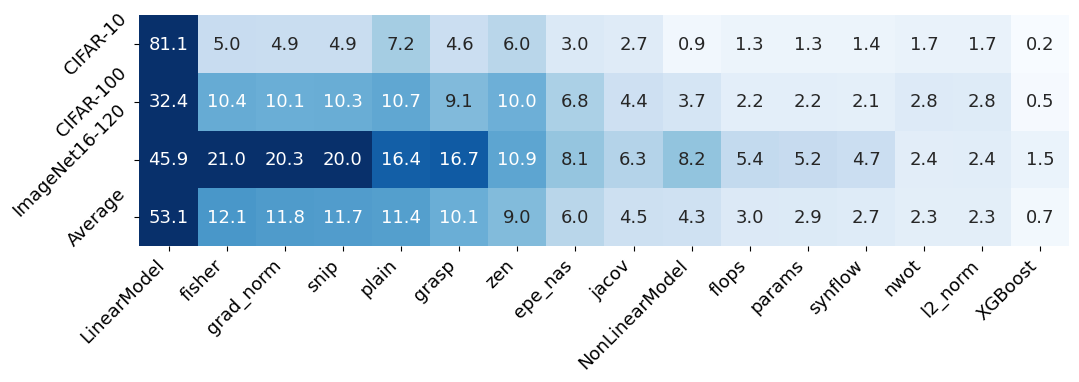

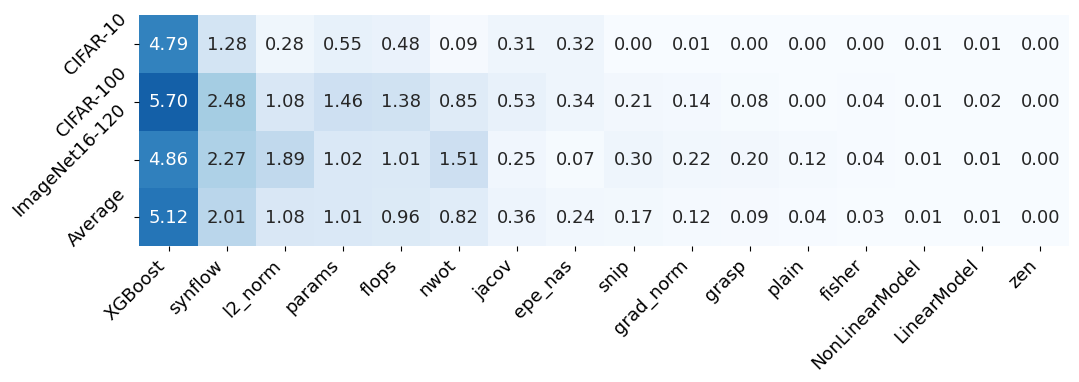

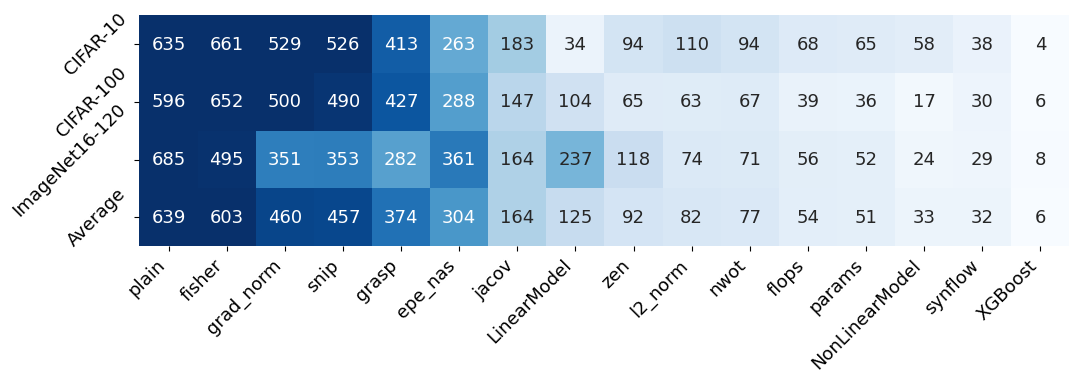

In [26]:
# Call the function with the desired DataFrame and vmax_value
plot_heatmap(Average_Difference_df, 20, 1)

# Call the function with the desired DataFrame and vmax_value
plot_heatmap(Average_Count_df, 7, 2)

# Call the function with the desired DataFrame and vmax_value
plot_heatmap(Average_Ranking_df, 500, 0)

In [60]:
class XGBoostWrapper:
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
        self.y_pred = {}
    
    def fit(self, train_loader):
        X_train, y_train = self._concatenate_loader_data(train_loader)
        self.model.fit(X_train, y_train)
    
    def predict(self, data_loader):
        X, _ = self._concatenate_loader_data(data_loader)
        return self.model.predict(X)
    
    def _concatenate_loader_data(self, loader):
        inputs_list, targets_list = [], []
        for inputs_batch, targets_batch in loader:
            # Assuming inputs are tensors and need to be converted to NumPy arrays
            inputs_list.append(inputs_batch.numpy())
            targets_list.append(targets_batch.numpy())
        # Concatenate all batches
        X = np.concatenate(inputs_list, axis=0)
        y = np.concatenate(targets_list, axis=0)
        return X, y
    
    def evaluate(self, data_loader):
        X, y_true = self._concatenate_loader_data(data_loader)
        self.y_pred = self.model.predict(X)
        return self.y_pred

In [134]:
def rank_and_check_test_check(model, data_loader):
    # Generate predictions using the model's custom predict method
    predictions = model.predict(data_loader)

    # Assuming predictions are returned as a numpy array; if not, you might need to convert them
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.numpy()

    # Collect targets from data_loader
    targets_list = []
    for _, targets in data_loader:
        targets_list.extend(targets.numpy())  # Assuming targets are tensors; adjust if not

    targets_flat = np.array(targets_list)

    sample_size = int(len(predictions) * 0.5)

    # Randomly select indices based on the calculated sample size, without replacement
    indices = np.random.choice(len(predictions), size=sample_size, replace=False)

    # Select the predictions and accuracy values for the sampled architectures
    sampled_predictions = predictions[indices]
    sampled_accuracy_values = targets_flat[indices]

    # Rank and compare as before
    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]

    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1

    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    
    top10_accuracy_in_top10_prediction = np.isin(top10_predictions_indices, top10_accuracy_indices).sum()
    

                    
    predicted_accuracies_np = np.array(sampled_predictions).flatten()
    actual_accuracies_np = np.array(sampled_accuracy_values).flatten()

    spearman_corr, spearman_p = spearmanr(predicted_accuracies_np, actual_accuracies_np)
    kendall_corr, kendalltau_p = kendalltau(predicted_accuracies_np, actual_accuracies_np)

    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position, spearman_corr, kendall_corr



Generalizability

In [ ]:
def rank_and_check_test_different(model, data_loader):
    # Generate predictions using the model's custom predict method
    predictions = model.predict(data_loader)

    # Assuming predictions are returned as a numpy array; if not, you might need to convert them
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.numpy()

    # Collect targets from data_loader
    targets_list = []
    for _, targets in data_loader:
        targets_list.extend(targets.numpy())  # Assuming targets are tensors; adjust if not

    targets_flat = np.array(targets_list)


    # Select the predictions and accuracy values for the sampled architectures
    sampled_predictions = predictions
    sampled_accuracy_values = targets_flat

    # Rank and compare as before
    sorted_by_predictions_indices = np.argsort(-sampled_predictions)
    actual_best_index = np.argmax(sampled_accuracy_values)
    best_by_prediction_accuracy = sampled_accuracy_values[sorted_by_predictions_indices[0]]
    actual_best_accuracy = sampled_accuracy_values[actual_best_index]

    accuracy_difference = actual_best_accuracy - best_by_prediction_accuracy
    actual_best_position = np.where(sorted_by_predictions_indices == actual_best_index)[0][0] + 1

    top10_predictions_indices = sorted_by_predictions_indices[:10]
    top10_accuracy_indices = np.argsort(-sampled_accuracy_values)[:10]
    
    top10_accuracy_in_top10_prediction = np.isin(top10_predictions_indices, top10_accuracy_indices).sum()

    return accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position

In [ ]:

from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
from scipy.stats import spearmanr, kendalltau
import numpy as np

datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
results_gen = {}

for data_train in datasets:
    inputs_train = torch.tensor(inputs[data_train], dtype=torch.float32)
    targets_train = torch.tensor(targets[data_train], dtype=torch.float32).view(-1, 1)
       
    # Initialize XGBoost with the wrapper and fit the model to the training data
    xgboost_model = XGBoostWrapper()
    train_loader = DataLoader(TensorDataset(inputs_train, targets_train), batch_size=batch_size, shuffle=True)
    xgboost_model.fit(train_loader)

    for data_test in datasets:
        for n in tqdm(range(1000), desc=f'Iteration loop for {data_train} Train, {data_test} Test'):
            test_name = f"{data_train} Train, {data_test} Test"
            if test_name not in results_gen:
                results_gen[test_name] = {'NoTrainArchs': [], 'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': [], 'Spearman': [], 'Kendall': []}

            inputs_test = torch.tensor(inputs[data_test], dtype=torch.float32)
            targets_test = torch.tensor(targets[data_test], dtype=torch.float32).view(-1, 1)

            # Randomly sample 1000 indices from the test set
            sample_size = min(1000, len(inputs_test))  # Ensure sample size does not exceed dataset size
            indices = np.random.choice(len(inputs_test), size=sample_size, replace=False)
            
            # Create a smaller test dataset using the sampled indices
            sampled_test_data = Subset(TensorDataset(inputs_test, targets_test), indices)

            NoTrainArchs = len(inputs_train)
            results_gen[test_name]['NoTrainArchs'].append(NoTrainArchs)
            
            # Create data loaders
            batch_size = 32

            test_loader = DataLoader(sampled_test_data, batch_size=batch_size, shuffle=False)
            
            # Evaluate the model
            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position = rank_and_check_test_different(xgboost_model, test_loader)
            results_gen[test_name]['accuracy_diffs'].append(accuracy_difference)
            results_gen[test_name]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)
            results_gen[test_name]['actual_best_positions'].append(actual_best_position)

            # Collect predicted and actual accuracies for Spearman and Kendall calculations
            predicted_accuracies = xgboost_model.evaluate(test_loader)
            actual_accuracies = [targets_batch.view(-1).cpu().numpy() for _, targets_batch in test_loader]
            actual_accuracies = np.concatenate(actual_accuracies)

            spearman_corr, _ = spearmanr(predicted_accuracies, actual_accuracies)
            kendall_corr, _ = kendalltau(predicted_accuracies, actual_accuracies)
            
            results_gen[test_name]['Spearman'].append(spearman_corr)
            results_gen[test_name]['Kendall'].append(kendall_corr)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Update matplotlib global font size for better readability
plt.rcParams.update({'font.size': 16})

# Prepare data for the Kendall confusion matrix
kendall_matrix = np.zeros((len(datasets), len(datasets)))
for i, train in enumerate(datasets):
    for j, test in enumerate(datasets):
        key = f"{train} Train, {test} Test"
        if key in results_gen and len(results_gen[key]['Kendall']) > 0:
            kendall_matrix[i, j] = np.mean(results_gen[key]['Kendall'])
        else:
            kendall_matrix[i, j] = np.nan

# Convert to DataFrame for better axis labeling in heatmap
kendall_df = pd.DataFrame(kendall_matrix, index=datasets, columns=datasets)
kendall_df.columns = [col.upper() for col in kendall_df.columns]
kendall_df.index = [idx.upper() for idx in kendall_df.index]

# Prepare data for the Spearman confusion matrix
spearman_matrix = np.zeros((len(datasets), len(datasets)))
for i, train in enumerate(datasets):
    for j, test in enumerate(datasets):
        key = f"{train} Train, {test} Test"
        if key in results_gen and len(results_gen[key]['Spearman']) > 0:
            spearman_matrix[i, j] = np.mean(results_gen[key]['Spearman'])
        else:
            spearman_matrix[i, j] = np.nan
            
        

# Prepare the matrix for accuracy_diffs
accuracy_diffs_matrix = np.zeros((len(datasets), len(datasets)))
for i, train in enumerate(datasets):
    for j, test in enumerate(datasets):
        key = f"{train} Train, {test} Test"
        if key in results_gen and len(results_gen[key]['accuracy_diffs']) > 0:
            # Calculate mean accuracy_diffs for this combination
            # Including cases where train and test datasets are the same
            accuracy_diffs_matrix[i, j] = np.mean(results_gen[key]['accuracy_diffs'])
        else:
            accuracy_diffs_matrix[i, j] = np.nan

# Convert to DataFrame for better axis labeling in heatmap
accuracy_diffs_df = pd.DataFrame(accuracy_diffs_matrix, index=datasets, columns=datasets)

# Adjust column and index names to uppercase for consistency
accuracy_diffs_df.columns = [col.upper() for col in accuracy_diffs_df.columns]
accuracy_diffs_df.index = [idx.upper() for idx in accuracy_diffs_df.index]

# Convert to DataFrame for better axis labeling in heatmap
spearman_df = pd.DataFrame(spearman_matrix, index=datasets, columns=datasets)
spearman_df.columns = [col.upper() for col in spearman_df.columns]
spearman_df.index = [idx.upper() for idx in spearman_df.index]

# Plotting the heatmap for both confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)  # Create subplots with shared y-axis

# Plot the Kendall confusion matrix
sns.heatmap(kendall_df, annot=True, cmap='Blues', fmt=".2f", vmin=0.5, vmax=1, cbar=False, ax=axes[1])
axes[1].set_title('Kendall', fontweight='bold', fontsize = 16)


# Plot the Spearman confusion matrix
sns.heatmap(spearman_df, annot=True, cmap='Blues', fmt=".2f", vmin=0.6, vmax=1, cbar=False, ax=axes[0])
axes[0].set_title('Spearman', fontweight='bold', fontsize = 16)
axes[0].set_ylabel('Train Dataset', fontweight='bold')
axes[0].set_ylabel('Train Dataset', fontweight='bold', fontsize = 16)

sns.heatmap(accuracy_diffs_df, annot=True, cmap='Blues', fmt=".2f", cbar=False, ax=axes[2])
axes[2].set_title('Average Accuracy Diff', fontweight='bold', fontsize = 16)


# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=45)
# axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45)
# axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=45)
fig.text(0.5, 0.02, 'Test Dataset', ha='center', fontweight='bold')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

Average Ranked Position

In [ ]:


from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, Subset
from scipy.stats import spearmanr, kendalltau
import numpy as np

datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
results_gen = {}

for data_train in datasets:
    inputs_train = torch.tensor(inputs[data_train], dtype=torch.float32)
    targets_train = torch.tensor(targets[data_train], dtype=torch.float32).view(-1, 1)
       
    # Initialize XGBoost with the wrapper and fit the model to the training data
    xgboost_model = XGBoostWrapper()
    train_loader = DataLoader(TensorDataset(inputs_train, targets_train), batch_size=batch_size, shuffle=True)
    xgboost_model.fit(train_loader)

    for data_test in datasets:
        for n in tqdm(range(1000), desc=f'Iteration loop for {data_train} Train, {data_test} Test'):
            test_name = f"{data_train} Train, {data_test} Test"
            if test_name not in results_gen:
                results_gen[test_name] = {'NoTrainArchs': [], 'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': [], 'Spearman': [], 'Kendall': []}

            inputs_test = torch.tensor(inputs[data_test], dtype=torch.float32)
            targets_test = torch.tensor(targets[data_test], dtype=torch.float32).view(-1, 1)

            # Randomly sample 1000 indices from the test set
            sample_size = min(1000, len(inputs_test))  # Ensure sample size does not exceed dataset size
            indices = np.random.choice(len(inputs_test), size=sample_size, replace=False)
            
            # Create a smaller test dataset using the sampled indices
            sampled_test_data = Subset(TensorDataset(inputs_test, targets_test), indices)

            NoTrainArchs = len(inputs_train)
            results_gen[test_name]['NoTrainArchs'].append(NoTrainArchs)
            
            # Create data loaders
            batch_size = 32

            test_loader = DataLoader(sampled_test_data, batch_size=batch_size, shuffle=False)
            
            # Evaluate the model
            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position = rank_and_check_test_different(xgboost_model, test_loader)
            results_gen[test_name]['accuracy_diffs'].append(accuracy_difference)
            results_gen[test_name]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)
            results_gen[test_name]['actual_best_positions'].append(actual_best_position)

            # Collect predicted and actual accuracies for Spearman and Kendall calculations
            predicted_accuracies = xgboost_model.evaluate(test_loader)
            actual_accuracies = [targets_batch.view(-1).cpu().numpy() for _, targets_batch in test_loader]
            actual_accuracies = np.concatenate(actual_accuracies)

            spearman_corr, _ = spearmanr(predicted_accuracies, actual_accuracies)
            kendall_corr, _ = kendalltau(predicted_accuracies, actual_accuracies)
            
            results_gen[test_name]['Spearman'].append(spearman_corr)
            results_gen[test_name]['Kendall'].append(kendall_corr)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_average_best_ranked_position(results):
    datasets = ['cifar10', 'cifar100', 'ImageNet16-120']
    
    # Prepare the matrix for actual_best_positions
    actual_best_positions_matrix = np.zeros((len(datasets), len(datasets)))
    for i, train in enumerate(datasets):
        for j, test in enumerate(datasets):
            key = f"{train} Train, {test} Test"
            if key in results and len(results[key]['actual_best_positions']) > 0:
                # Calculate mean actual_best_positions for this combination
                # Including cases where train and test datasets are the same
                actual_best_positions_matrix[i, j] = np.mean(results[key]['actual_best_positions'])
            else:
                actual_best_positions_matrix[i, j] = np.nan

    # Convert to DataFrame for better axis labeling in heatmap
    actual_best_positions_df = pd.DataFrame(actual_best_positions_matrix, index=datasets, columns=datasets)

    # Adjust column and index names to uppercase for consistency
    actual_best_positions_df.columns = [col.upper() for col in actual_best_positions_df.columns]
    actual_best_positions_df.index = [idx.upper() for idx in actual_best_positions_df.index]

    # Plotting the heatmap for actual_best_positions
    plt.figure(figsize=(4, 4))
    sns.heatmap(actual_best_positions_df, annot=True, cmap='Blues', fmt=".0f", cbar=False)
    plt.title('Average Best Ranked Position', fontweight='bold')
    plt.xlabel('Test Dataset', fontweight='bold', fontsize=15)
    plt.ylabel('Train Dataset', fontweight='bold', fontsize=15)
    plt.xticks(rotation=45, ha='right', fontsize=15)  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0, fontsize=15)  # Rotate y-axis labels for consistency
    plt.show()
    
plot_average_best_ranked_position(results_gen)

Required Number of Archs

In [138]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm
# Convert lists to PyTorch tensors

results_wide_range = {}

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    results_wide_range[data_type] = {'NoTrainArchs': [], 'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': [], 'Spearman': [], 'Kendall': []}

    inputs_tensor = torch.tensor(inputs[data_type], dtype=torch.float32)
    targets_tensor = torch.tensor(targets[data_type], dtype=torch.float32).view(-1, 1)
    for split in tqdm(np.linspace(0.005, 0.995, num=20), desc=f'Iteration loop for {data_type}'):
        
        # Assuming inputs and targets are already defined as PyTorch tensors

        # Split the data into train+validation and test sets
        inputs_train, inputs_test, targets_train, targets_test = train_test_split(
            inputs_tensor, targets_tensor, test_size=split)
        
        NoTrainArchs = len(inputs_train)
        
        results_wide_range[data_type]['NoTrainArchs'].append(NoTrainArchs)
        # Create TensorDataset instances for each set
        train_data = TensorDataset(inputs_train, targets_train)
        test_data = TensorDataset(inputs_test, targets_test)

        # Create data loaders
        batch_size = 32  # Adjust batch size as needed
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        # Initialize XGBoost with the wrapper
        xgboost_model = XGBoostWrapper()

        # Fit the model to the training data
        xgboost_model.fit(train_loader)
        
        for n in range(10):
            # General Metric Correlations
            
            
            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position, spearman_corr, kendall_corr = rank_and_check_test_check(xgboost_model, test_loader)
            
            results_wide_range[data_type]['accuracy_diffs'].append(accuracy_difference)
            results_wide_range[data_type]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)
            results_wide_range[data_type]['actual_best_positions'].append(actual_best_position)


            
            results_wide_range[data_type]['Spearman'].append(spearman_corr)
            results_wide_range[data_type]['Kendall'].append(kendall_corr)
            

Iteration loop for ImageNet16-120: 100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


In [149]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Import tqdm
# Convert lists to PyTorch tensors

results_small_range = {}

for data_type in ['cifar10', 'cifar100', 'ImageNet16-120']:
    results_small_range[data_type] = {'NoTrainArchs': [], 'accuracy_diffs': [], 'top10_accuracy_count': [], 'actual_best_positions': [], 'Spearman': [], 'Kendall': []}

    inputs_tensor = torch.tensor(inputs[data_type], dtype=torch.float32)
    targets_tensor = torch.tensor(targets[data_type], dtype=torch.float32).view(-1, 1)
    for split in tqdm(np.linspace(0.99, 0.9999, num=20), desc=f'Iteration loop for {data_type}'):
        
        # Assuming inputs and targets are already defined as PyTorch tensors

        # Split the data into train+validation and test sets
        inputs_train, inputs_test, targets_train, targets_test = train_test_split(
            inputs_tensor, targets_tensor, test_size=split)
        
        NoTrainArchs = len(inputs_train)
        
        results_small_range[data_type]['NoTrainArchs'].append(NoTrainArchs)
        # Create TensorDataset instances for each set
        train_data = TensorDataset(inputs_train, targets_train)
        test_data = TensorDataset(inputs_test, targets_test)

        # Create data loaders
        batch_size = 32  # Adjust batch size as needed
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

        # Initialize XGBoost with the wrapper
        xgboost_model = XGBoostWrapper()

        # Fit the model to the training data
        xgboost_model.fit(train_loader)
        
        for n in range(5):
            # General Metric Correlations
            
            
            accuracy_difference, top10_accuracy_in_top10_prediction, actual_best_position, spearman_corr, kendall_corr = rank_and_check_test_check(xgboost_model, test_loader)
            
            results_small_range[data_type]['accuracy_diffs'].append(accuracy_difference)
            results_small_range[data_type]['top10_accuracy_count'].append(top10_accuracy_in_top10_prediction)
            results_small_range[data_type]['actual_best_positions'].append(actual_best_position)


            
            results_small_range[data_type]['Spearman'].append(spearman_corr)
            results_small_range[data_type]['Kendall'].append(kendall_corr)
            

Iteration loop for cifar10:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration loop for cifar10:   0%|          | 0/20 [00:35<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def process_dataset(data_info):
    # Initialize a dictionary to hold aggregated metrics for each unique architecture number
    unique_archs = {}
    
    no_train_archs = data_info['NoTrainArchs']
    
    # Iterate over the NoTrainArchs and corresponding metrics, aggregating them
    for idx, arch in enumerate(no_train_archs):
        if arch not in unique_archs:
            unique_archs[arch] = {'NumArchs': arch, 'accuracy_diffs': [], 'top10_accuracy_count': [],
                                  'actual_best_positions': [], 'Spearman': [], 'Kendall': []}
             
        unique_archs[arch]['accuracy_diffs'].append(data_info['accuracy_diffs'][idx])
        unique_archs[arch]['top10_accuracy_count'].append(data_info['top10_accuracy_count'][idx])
        unique_archs[arch]['actual_best_positions'].append(data_info['actual_best_positions'][idx])
        unique_archs[arch]['Spearman'].append(data_info['Spearman'][idx])
        unique_archs[arch]['Kendall'].append(data_info['Kendall'][idx])

    # Calculate averages for each metric in unique_archs in a separate step
    for arch, metrics in unique_archs.items():
        for metric in ['accuracy_diffs', 'top10_accuracy_count', 'actual_best_positions', 'Spearman', 'Kendall']:
            if metric in metrics:  # Check if metric data exists to avoid division by zero
                metrics[metric] = sum(metrics[metric]) / len(metrics[metric]) if metrics[metric] else 0

    return unique_archs

# Process each dataset
processed_results_wide_range = {dataset: process_dataset(info) for dataset, info in results_wide_range.items()}

processed_results_small_range = {dataset: process_dataset(info) for dataset, info in results_small_range.items()}

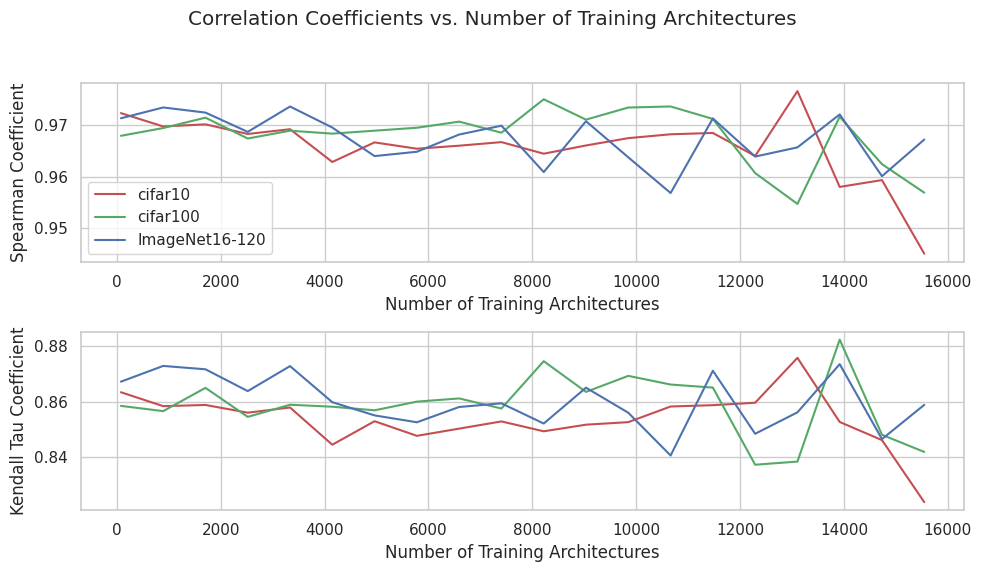

In [141]:
# Creating separate DataFrames for each dataset
data_frames = {}
for data_type, metrics in processed_results_wide_range.items():
    df = pd.DataFrame.from_dict(metrics).T
    data_frames[data_type] = df

# Accessing each DataFrame
cifar10_df = data_frames['cifar10']
cifar100_df = data_frames['cifar100']
imagenet16_120_df = data_frames['ImageNet16-120']


# Setting the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Creating the plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=False)

colors = {'cifar10': 'r', 'cifar100': 'g', 'ImageNet16-120': 'b'}

# Plotting Spearman coefficients
for data_type, df in data_frames.items():
    axes[0].plot(df['NumArchs'], df['Spearman'], label=data_type, color=colors[data_type])
axes[0].set_xlabel('Number of Training Architectures')
axes[0].set_ylabel('Spearman Coefficient')
axes[0].legend()

# Plotting Kendall coefficients
for data_type, df in data_frames.items():
    axes[1].plot(df['NumArchs'], df['Kendall'], label=data_type, color=colors[data_type])
axes[1].set_xlabel('Number of Training Architectures')
axes[1].set_ylabel('Kendall Tau Coefficient')
# No need for y-label as it shares with Spearman's plot (sharey=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the global title
plt.show()


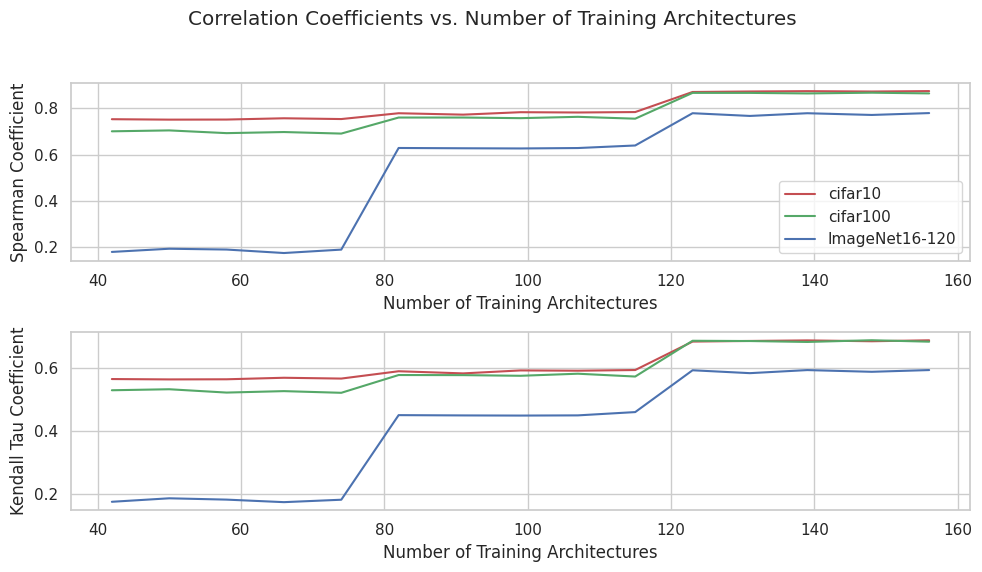

In [150]:
# Creating separate DataFrames for each dataset
data_frames = {}
for data_type, metrics in processed_results_small_range.items():
    df = pd.DataFrame.from_dict(metrics).T
    data_frames[data_type] = df

# Accessing each DataFrame
cifar10_df = data_frames['cifar10']
cifar100_df = data_frames['cifar100']
imagenet16_120_df = data_frames['ImageNet16-120']


# Setting the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Creating the plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=False)

colors = {'cifar10': 'r', 'cifar100': 'g', 'ImageNet16-120': 'b'}

# Plotting Spearman coefficients
for data_type, df in data_frames.items():
    axes[0].plot(df['NumArchs'], df['Spearman'], label=data_type, color=colors[data_type])
axes[0].set_xlabel('Number of Training Architectures')
axes[0].set_ylabel('Spearman Coefficient')
axes[0].legend()

# Plotting Kendall coefficients
for data_type, df in data_frames.items():
    axes[1].plot(df['NumArchs'], df['Kendall'], label=data_type, color=colors[data_type])
axes[1].set_xlabel('Number of Training Architectures')
axes[1].set_ylabel('Kendall Tau Coefficient')
# No need for y-label as it shares with Spearman's plot (sharey=True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the global title
plt.show()


TypeError: Legend.__init__() got an unexpected keyword argument 'location'

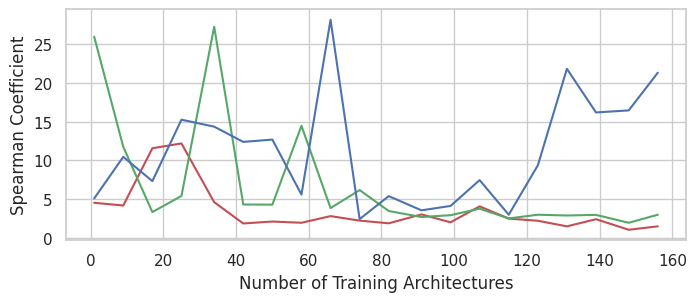

In [161]:
# Creating separate DataFrames for each dataset
data_frames = {}
for data_type, metrics in processed_results_small_range.items():
    df = pd.DataFrame.from_dict(metrics).T
    data_frames[data_type] = df

# Accessing each DataFrame
cifar10_df = data_frames['cifar10']
cifar100_df = data_frames['cifar100']
imagenet16_120_df = data_frames['ImageNet16-120']


# Setting the Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Creating the plot
fig = plt.figure(figsize=(8, 3))

colors = {'cifar10': 'r', 'cifar100': 'g', 'ImageNet16-120': 'b'}

# Plotting Spearman coefficients
for data_type, df in data_frames.items():
    plt.plot(df['NumArchs'], df['accuracy_diffs'], label=data_type.upper(), color=colors[data_type])
plt.xlabel('Number of Training Architectures')
plt.ylabel('Spearman Coefficient')
plt.legend(location = 'best')


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the layout to make room for the global title
plt.show()
